In [1]:
import torch
from ResNet import *
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import PIL
from voxel2layer import decode_shape, generate_indices
from voxel2layer_torch import shlx2shl, shl2shlx, generate_indices as torch_generate_indices
from train import iou_shapelayer
from binvox_rw import Voxels, dense_to_sparse
import numpy as np
import glob
import scipy.io as sio

from crop_images import load_image, crop_image

R2N2_3D_DATASET = '/raid/rustam/danil/datasets/shapenet/3d_r2n2'

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
savegame = torch.load('results/matryoshka_ShapeNet_37.pth.tar')

In [802]:
net = ResNet(
    num_input_channels=3, 
    num_initial_channels=savegame['ninf'],
    num_inner_channels=savegame['ngf'],
    num_penultimate_channels=savegame['noutf'], 
    num_output_channels=6*1,
    input_resolution=128, 
    output_resolution=savegame['side'],
    num_downsampling=savegame['down'], 
    num_blocks=savegame['block']
)
net.load_state_dict(savegame['state_dict'])

<All keys matched successfully>

In [803]:
_ = net.eval()

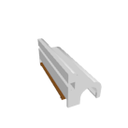

(None, (128, 128), '5d9dd008caf920b8c29a08a3db9fbe1')

In [821]:
is_zoom = False
is_white = True

if is_white and is_zoom:
    map_to = 255
    back_v = 255
elif is_white and not is_zoom:
    map_to = 255
    back_v = 128
elif not is_white and is_zoom:
    map_to = 128
    back_v = 128
elif not is_white and not is_zoom:
    map_to = 128
    back_v = 255
    

class_path = '{R2N2_3D_DATASET}/ShapeNetRendering/02828884/'
all_obj_path = glob.glob(f'{class_path}/*')
random_obj = all_obj_path[np.random.randint(0, len(all_obj_path))]
data_path = f'{random_obj}/rendering/02.png'
img = Image.open(data_path)
img = load_image(img, alpha_map_to=map_to)
img = crop_image(img, 128, background_value=back_v)
img.show(), img.size, random_obj.split('/')[-1]

In [807]:
input_tensor = np.array(img)
input_tensor = torch.from_numpy(input_tensor)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.float() / 255.0
input_tensor = input_tensor.permute(0, -1, 1, 2)

predicted_original_tensor = net(input_tensor).detach()
predicted_tensor = shlx2shl(predicted_original_tensor.clone().detach())
predicted_tensor = predicted_tensor.detach()
predicted_tensor = predicted_tensor.permute(0, 2, 3, 1)

split_data_path = data_path.split('/')
d = sio.loadmat(f'{R2N2_3D_DATASET}/ShapeNetVox32/{split_data_path[-4]}/{split_data_path[-3]}/model.shl.mat')
sh = torch.from_numpy(np.array(d['shapelayer'], dtype=np.int32)[:,:,:6*1]).permute(2,0,1).contiguous().float() 

id1_t, id2_t, id3_t = torch_generate_indices(32)
pred = shlx2shl(predicted_original_tensor.clone().detach())
target = sh.clone().detach().unsqueeze(0)
iou, bs  = iou_shapelayer(pred, target, id1_t, id2_t, id3_t)
iou

tensor(0.7774)

<AxesSubplot:>

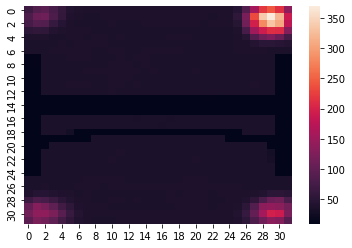

In [808]:
#sns.heatmap(predicted_original_tensor[0,0,:])
sns.heatmap(predicted_tensor[0,:,:, 0])

(<AxesSubplot:>, tensor(34.))

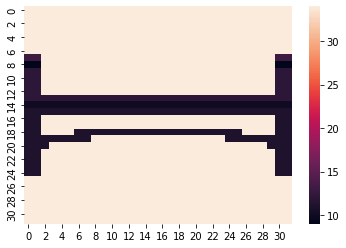

In [809]:
sns.heatmap(sh[0]), sh[:,].max()

In [605]:
id1, id2, id3 = generate_indices(32)
decoded = decode_shape(sh.permute(1, 2, 0), id1, id2, id3)
#decoded = (decoded > 1e-3).astype(int)
decoded.shape, decoded.sum(), decoded.max(), decoded.min()

((32, 32, 32), 660, 1, 0)

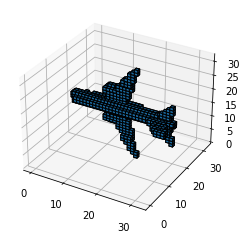

In [606]:
fig = plt.figure()
ax = plt.subplot(projection='3d')

ax.voxels(decoded, edgecolors='k')
plt.show()

In [607]:
id1, id2, id3 = generate_indices(32)
decoded = predicted_tensor.detach()
decoded = decode_shape(decoded[0], id1, id2, id3)
#decoded = (decoded > 1e-3).astype(int)
decoded.shape, decoded.sum(), decoded.max(), decoded.min()

((32, 32, 32), 587, 1, 0)

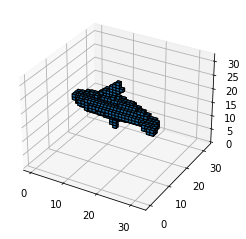

In [608]:
fig = plt.figure()
ax = plt.subplot(projection='3d')

ax.voxels(decoded, edgecolors='k')
plt.show()

In [368]:
voxel_model = Voxels(decoded, [32, 32, 32],np.array([0.4,0.4,0.5]),1.2,'xyz')

In [ ]:
with open('result.binvox', 'a') as f:
    voxel_model.write(f)

In [ ]:
pred    = net(input_tensor)

In [ ]:
from voxel2layer_torch import shlx2shl

sh = shlx2shl(pred)

In [ ]:
from train import iou_voxel, iou_shapelayer

iou, bs = iou_shapelayer(sh, targets, id1, id2, id3)

In [ ]:
# https://raahii.github.io/simple_voxel_viewer/index.html
# https://drububu.com/miscellaneous/voxelizer/?out=obj